Target moments: [ 0.199  0.229 -0.04  -0.075  0.068 -0.265  0.115  0.169 -0.062 -0.195]
Closed-form error: 0.0 (time 0.008s, iter 5, success=True)
MWU error: 0.0 (time 0.004s)
Streaming MWU error: 0.0042 (time 0.022s)

--- Adaptation test: shifting target moments mid-stream ---
Shifted target error: 0.0028

--- High-dimension test (d = 100) ---
Closed-form (high-dim) error: 0.0001 (time 1.184s, iter 44, success=True)
MWU (high-dim) final error: 0.0 (time 0.081s)


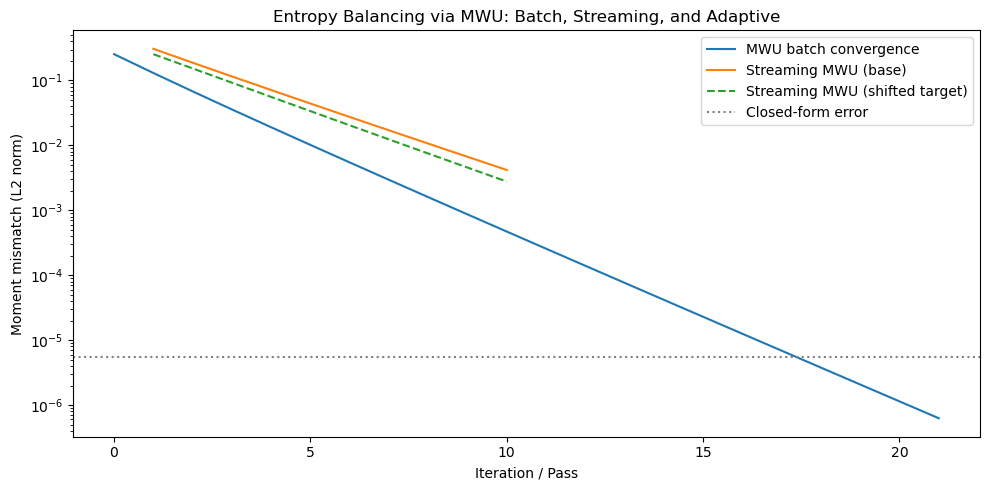

In [24]:
# MWU vs Closed-Form Entropy Balancing: Comparison Suite
# ======================================================
# This script compares entropy balancing using:
# (1) Closed-form solution via convex optimization
# (2) Multiplicative Weights Update (MWU) iterative scheme
# It then demonstrates MWU advantages in streaming, adaptation, and scaling.
# This version adds a high-dimensional test case where BFGS struggles to converge.

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import time
import warnings

np.random.seed(42)

# ------------------------------------------------------------------
# 1. Simulate sample data and population target moments
# ------------------------------------------------------------------
def generate_data(n=1000, d=3):
    X = np.random.normal(size=(n, d))
    X = StandardScaler().fit_transform(X)
    pop_target = np.random.uniform(-0.3, 0.3, size=d)
    return X, pop_target

# ------------------------------------------------------------------
# 2. Closed-form entropy balancing via convex solver
# ------------------------------------------------------------------
def entropy_balancing_closed_form(X, target, verbose=False):
    def objective(lam):
        w = np.exp(X @ lam)
        w /= np.sum(w)
        moment_diff = w @ X - target
        return 0.5 * np.sum(moment_diff ** 2)

    lam0 = np.zeros(X.shape[1])
    options = {'disp': verbose, 'maxiter': 200}
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        res = minimize(objective, lam0, method='BFGS', options=options)
    if not res.success:
        print("[BFGS WARNING]", res.message)
    lam = res.x
    w = np.exp(X @ lam)
    w /= np.sum(w)
    return w, res.nit, res.success

# ------------------------------------------------------------------
# 3. MWU entropy balancing
# ------------------------------------------------------------------
def entropy_balancing_mwu(X, target, eta=0.5, n_iter=1000, tol=1e-6):
    n, d = X.shape
    w = np.ones(n) / n
    history = []
    for t in range(n_iter):
        err = w @ X - target
        if np.linalg.norm(err) < tol:
            break
        grad = X @ err
        w *= np.exp(-eta * grad)
        w /= np.sum(w)
        history.append(np.linalg.norm(w @ X - target))
    return w, np.array(history)

# ------------------------------------------------------------------
# 4. Streaming MWU updates with revisits per epoch
# ------------------------------------------------------------------
def mwu_streaming(X, target, eta=0.5, batch_size=50, n_passes=3):
    n, d = X.shape
    w = np.ones(n) / n
    err_trace = []
    for epoch in range(n_passes):
        for i in range(0, n, batch_size):
            idx = slice(i, min(i+batch_size, n))
            Xb = X[idx]
            error = w @ X - target
            grad = Xb @ error
            w[idx] *= np.exp(-eta * grad)
            w /= np.sum(w)
        err_trace.append(np.linalg.norm(w @ X - target))
    return w, np.array(err_trace)

# ------------------------------------------------------------------
# 5. Run experiments
# ------------------------------------------------------------------
if __name__ == "__main__":
    # ----------- Base experiment --------------
    X, target = generate_data(n=3000, d=10)
    print("Target moments:", target.round(3))

    # Closed-form baseline
    t0 = time.time()
    w_closed, nit, success = entropy_balancing_closed_form(X, target)
    t1 = time.time()
    print("Closed-form error:", np.linalg.norm(w_closed @ X - target).round(4), f"(time {t1 - t0:.3f}s, iter {nit}, success={success})")

    # MWU solver
    t0 = time.time()
    w_mwu, hist = entropy_balancing_mwu(X, target)
    t1 = time.time()
    print("MWU error:", np.linalg.norm(w_mwu @ X - target).round(4), f"(time {t1 - t0:.3f}s)")

    # Streaming update with revisits
    t0 = time.time()
    w_stream, stream_err = mwu_streaming(X, target, eta=0.5, batch_size=50, n_passes=10)
    t1 = time.time()
    print("Streaming MWU error:", np.linalg.norm(w_stream @ X - target).round(4), f"(time {t1 - t0:.3f}s)")

    # ----------- Dynamic target experiment --------------
    print("\n--- Adaptation test: shifting target moments mid-stream ---")
    target2 = np.random.uniform(-0.3, 0.3, size=X.shape[1])
    w_shift, err_shift = mwu_streaming(X, target2, eta=0.5, batch_size=50, n_passes=10)
    print("Shifted target error:", np.linalg.norm(w_shift @ X - target2).round(4))

    # ----------- High-dimensional test --------------
    print("\n--- High-dimension test (d = 100) ---")
    X_hd, target_hd = generate_data(n=3000, d=100)
    t0 = time.time()
    w_bfgs_hd, nit_hd, success_hd = entropy_balancing_closed_form(X_hd, target_hd)
    t1 = time.time()
    print("Closed-form (high-dim) error:", np.linalg.norm(w_bfgs_hd @ X_hd - target_hd).round(4), f"(time {t1 - t0:.3f}s, iter {nit_hd}, success={success_hd})")

    t0 = time.time()
    _, err_hd = entropy_balancing_mwu(X_hd, target_hd, eta=0.25, n_iter=500)
    t1 = time.time()
    print("MWU (high-dim) final error:", err_hd[-1].round(4), f"(time {t1 - t0:.3f}s)")

    # ----------- Plotting ----------------------------
    plt.figure(figsize=(10, 5))
    plt.plot(hist, label='MWU batch convergence')
    plt.plot(np.arange(1, len(stream_err)+1), stream_err, label='Streaming MWU (base)')
    plt.plot(np.arange(1, len(err_shift)+1), err_shift, label='Streaming MWU (shifted target)', ls='--')
    plt.axhline(np.linalg.norm(w_closed @ X - target), ls=':', c='gray', label='Closed-form error')
    plt.yscale('log')
    plt.xlabel("Iteration / Pass")
    plt.ylabel("Moment mismatch (L2 norm)")
    plt.title("Entropy Balancing via MWU: Batch, Streaming, and Adaptive")
    plt.legend()
    plt.tight_layout()
    plt.show()